In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

In [214]:
import warnings
warnings.filterwarnings('ignore')

In [215]:
from Ingestion.kivadataloader import KivaDataLoader
m=KivaDataLoader()
cleaneduploans=m.get_clean_dataframe()

Connected to kivateam.cnd5idfvxmld.us-east-1.rds.amazonaws.com:5432/kiva
The process takes about 5 minutes to run.


In [216]:
cleaneduploans.shape

(1170548, 66)

# Target and Features

In [386]:
#Target
cleaneduploans['fol']=np.where(cleaneduploans['posted_to_raised_days']<=5,0,1)

In [387]:
y=cleaneduploans['fol']

In [388]:
y.shape

(1170548,)

In [389]:
#Features
X=cleaneduploans.drop(['week','posted_to_raised_days','posted_to_raised_bins', 'disburse_to_posted_days','disbursed_to_raised_days','loan_id','partner_id', 'funded_amount','loan_image_provided','atleast1_borrower_pictured','distribution_model_field_partner','num_borrowers', 'num_borrowers_male', 'num_borrowers_female', 'num_journal_entries','num_bulk_entries','loan_video_provided','sector_name_Food','repayment_interval_monthly'], axis=1)

In [390]:
X=X.drop([col for col in X.columns if 'partner_' in col],axis=1)

In [391]:
X.shape

(1170548, 35)

In [392]:
#To keep only numeric variables
X = X.select_dtypes(exclude=['object','datetime64[ns, UTC]'])

In [393]:
X.shape

(1170548, 24)

In [394]:
X[X.columns[X.isnull().any()].tolist()].isnull().sum()

description_length                     26
loan_use_length                        16
currency_exchange_coverage_rate    263865
dtype: int64

In [395]:
#Replace nan values with 0 for description and loan_use lenght 
X['description_length'].fillna(0,inplace=True)
X['loan_use_length'].fillna(0,inplace=True)

In [396]:
#Remove columns with nan values 
X.dropna(axis=1, inplace=True)

In [397]:
for i in X.isnull():
    if i == True:
        print (i)
print('no more missing values')

no more missing values


In [398]:
X.shape

(1170548, 23)

In [399]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [400]:
model = Lasso(alpha=0.5)
sfm = SelectFromModel(model)
sfm.fit(X, y)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['description_length', 'loan_amount', 'loan_use_length']


In [401]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(X, y)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['tags_exist', 'num_borrowers_female_pct', 'sector_name_Arts', 'sector_name_Education', 'sector_name_Health', 'sector_name_Manufacturing', 'sector_name_Personal Use', 'repayment_interval_irregular']


In [402]:
model = ElasticNet()
sfm = SelectFromModel(model)
sfm.fit(X, y)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['description_length', 'loan_amount', 'loan_use_length']


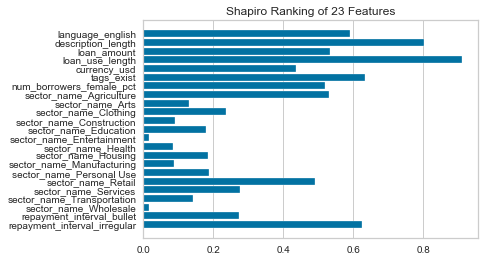

In [403]:
from yellowbrick.features import Rank1D

# Instantiate the 1D visualizer with the Sharpiro ranking algorithm
visualizer = Rank1D(features=X.columns, algorithm='shapiro')

visualizer.fit(X, y)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof()                     # Draw/show/poof the data

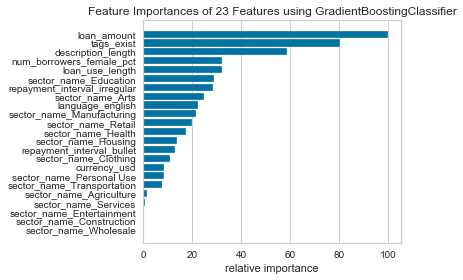

In [404]:
from sklearn.ensemble import GradientBoostingClassifier

from yellowbrick.features.importances import FeatureImportances

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

viz = FeatureImportances(GradientBoostingClassifier(), ax=ax)
viz.fit(X, y)
viz.poof()

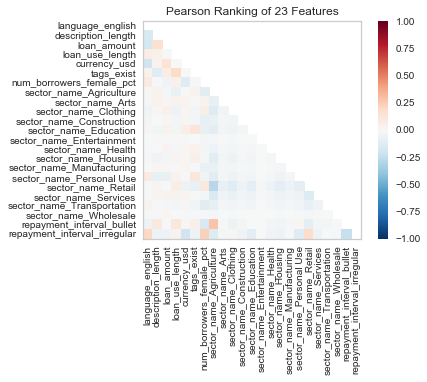

In [405]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(features=X.columns, algorithm='pearson')

visualizer.fit(X, y)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof()                   # Draw/show/poof the data

In [406]:
pca = PCA(n_components=2)
pca_f = pca.fit(X).transform(X)

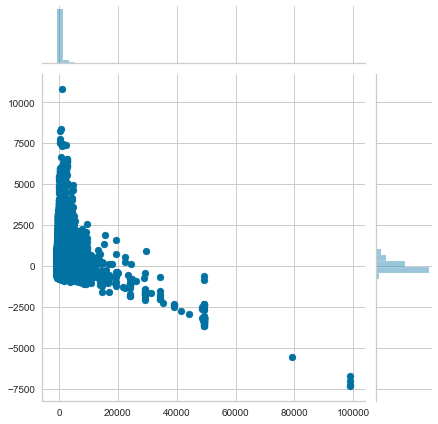

In [407]:
sns.jointplot(pca_f[:,0], pca_f[:,1])

# Train and Test

In [408]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [366]:
X=scale(X)

In [409]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=1)

In [410]:
y.value_counts(normalize=True)

1    0.533741
0    0.466259
Name: week, dtype: float64

In [411]:
y_train.value_counts(normalize=True)

1    0.534126
0    0.465874
Name: week, dtype: float64

In [412]:
y_test.value_counts(normalize=True)

1    0.532199
0    0.467801
Name: week, dtype: float64

# Model 1: Naive Approach

In [284]:
from sklearn.naive_bayes import GaussianNB

In [285]:
nb = GaussianNB()

In [413]:
nb.fit(X_train, y_train)

GaussianNB(priors=None)

In [414]:
expected   = y_test
predicted  = nb.predict(X_test)
classificationReport = classification_report(expected, predicted, target_names=['1 week or less','More than 1 week'])
print(classificationReport)

                  precision    recall  f1-score   support

  1 week or less       0.59      0.60      0.59    109517
More than 1 week       0.64      0.64      0.64    124593

     avg / total       0.62      0.62      0.62    234110



# Model 2: Logistic Regression

In [288]:
from sklearn.linear_model import LogisticRegression

In [292]:
lr = LogisticRegression()

In [415]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [416]:
expected   = y_test
predicted  = lr.predict(X_test)
classificationReport = classification_report(expected, predicted, target_names=['1 week or less','More than 1 week'])
print(classificationReport)

                  precision    recall  f1-score   support

  1 week or less       0.63      0.62      0.62    109517
More than 1 week       0.67      0.67      0.67    124593

     avg / total       0.65      0.65      0.65    234110



# Model 3: Random Forest

In [376]:
from sklearn.ensemble import RandomForestClassifier

In [429]:
rf = RandomForestClassifier(n_estimators=100)

In [430]:
model=rf.fit(X_train, y_train)

In [431]:
expected   = y_test
predicted  = rf.predict(X_test)
classificationReport = classification_report(expected, predicted, target_names=['1 week or less','More than 1 week'])
print(classificationReport)

                  precision    recall  f1-score   support

  1 week or less       0.62      0.60      0.61    109517
More than 1 week       0.66      0.68      0.67    124593

     avg / total       0.64      0.64      0.64    234110



# Model 4: SVM

In [422]:
from sklearn.svm import LinearSVC

In [423]:
model = LinearSVC()

In [424]:
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [425]:
expected   = y_test
predicted  = model.predict(X_test)

classificationReport = classification_report(expected, predicted, target_names=['1 week or less','More than 1 week'])
print(classificationReport)

                  precision    recall  f1-score   support

  1 week or less       0.48      0.89      0.62    109517
More than 1 week       0.59      0.14      0.23    124593

     avg / total       0.54      0.49      0.41    234110



# Model 5: LDA

In [420]:
lda = LDA(n_components=2)
lda_f = lda.fit(X_train,y_train)

In [421]:
expected   = y_test
predicted  = lda.predict(X_test)
classificationReport = classification_report(expected, predicted, target_names=['1 week','2 week', '3 week', '4 week'])
print(classificationReport)

             precision    recall  f1-score   support

     1 week       0.62      0.63      0.63    109517
     2 week       0.67      0.66      0.67    124593

avg / total       0.65      0.65      0.65    234110

